In [32]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedGroupKFold

seed=42
root_path='/kaggle/input/playground-series-s4e4/'

In [11]:
def Pipe(df: pd.DataFrame):
    cols = df.select_dtypes('object').columns.tolist()
    df[cols] = df[cols].astype('category')
    
    return df

In [12]:
train = pd.read_csv(root_path + 'train.csv').pipe(Pipe)
test = pd.read_csv(root_path + 'test.csv').pipe(Pipe)

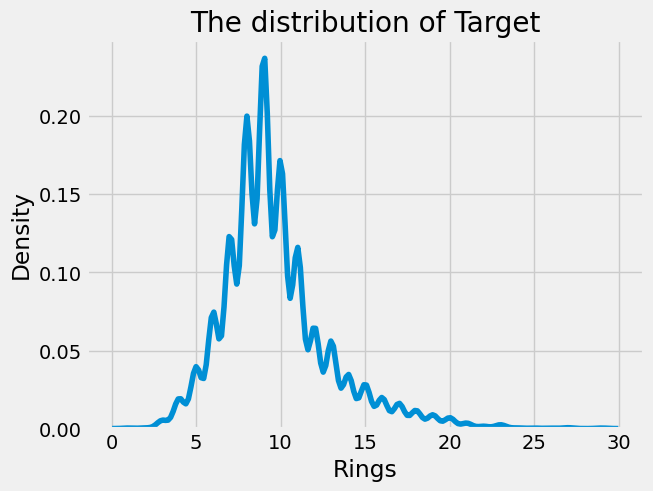

In [15]:
sns.kdeplot(data=train, x='Rings')
plt.title('The distribution of Target')

plt.show()

<Axes: xlabel='Rings', ylabel='Sex'>

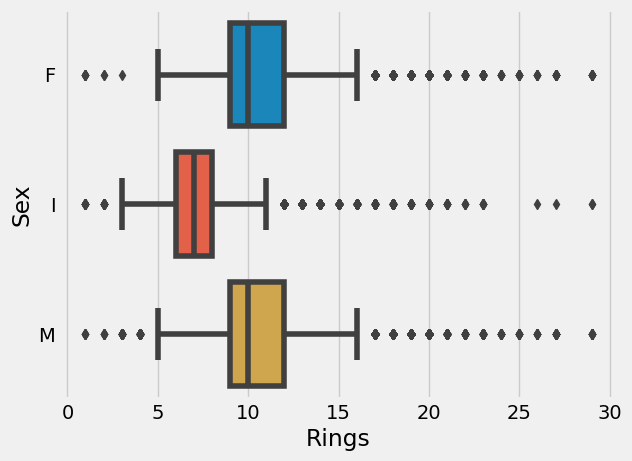

In [17]:
sns.boxplot(data=train, x='Rings', y='Sex')

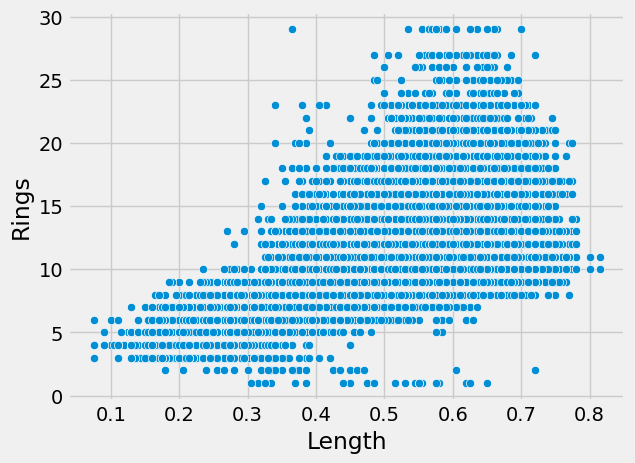

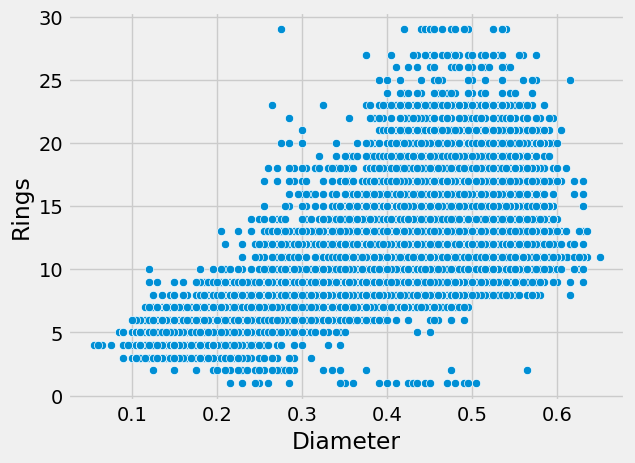

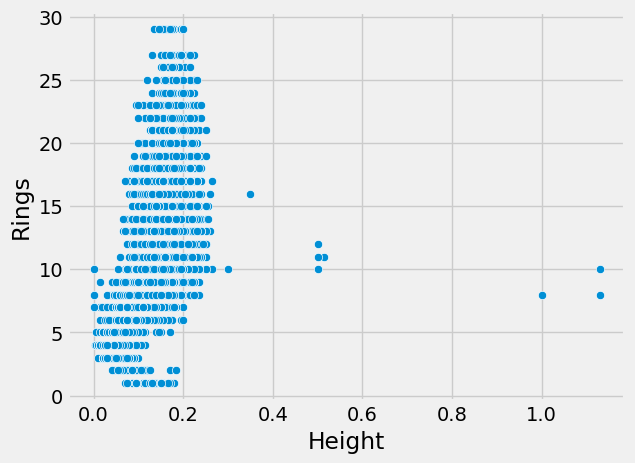

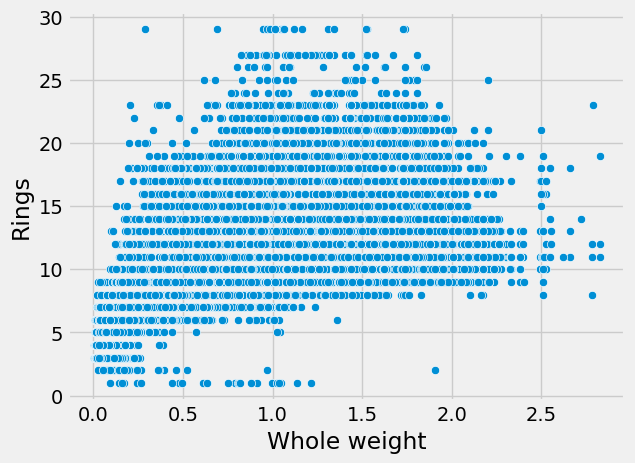

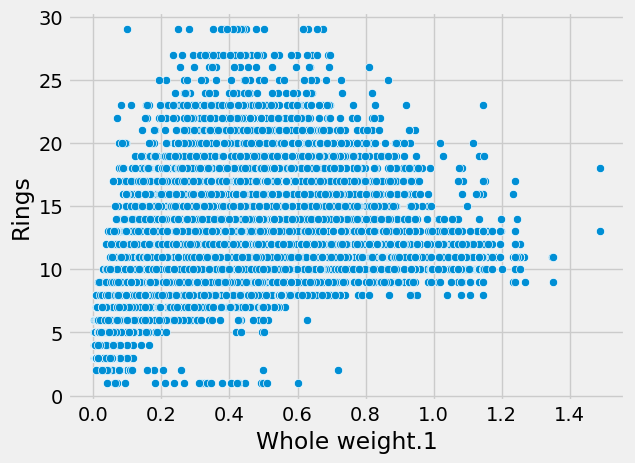

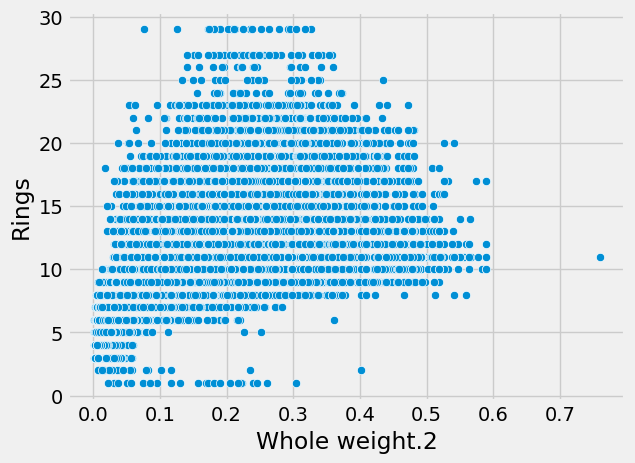

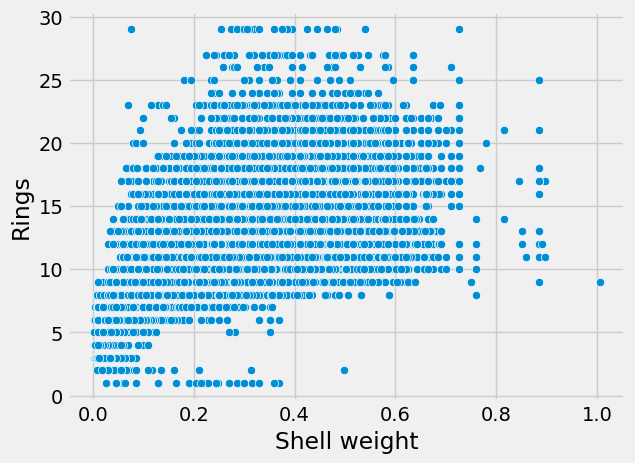

In [18]:
cols = train.drop(columns=['id', 'Rings', 'Sex']).columns.tolist()

for col in cols:
    
    sns.scatterplot(data=train, x=col, y='Rings')
    
    plt.show()

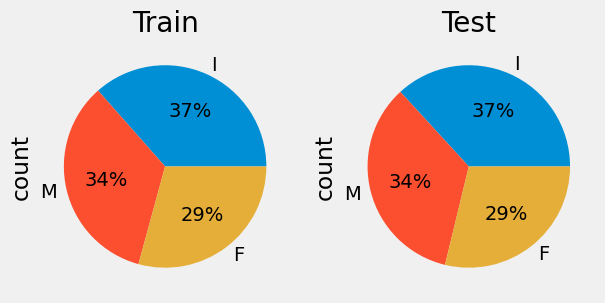

In [29]:
f, ax = plt.subplots(1, 2)
train['Sex'].value_counts().plot.pie(autopct='%0.0f%%', ax=ax[0])
ax[0].set_title('Train')

test['Sex'].value_counts().plot.pie(autopct='%0.0f%%', ax=ax[1])
ax[1].set_title('Test')

plt.show()

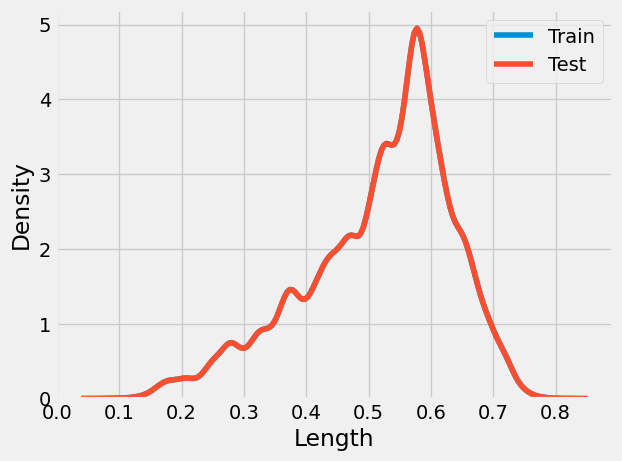

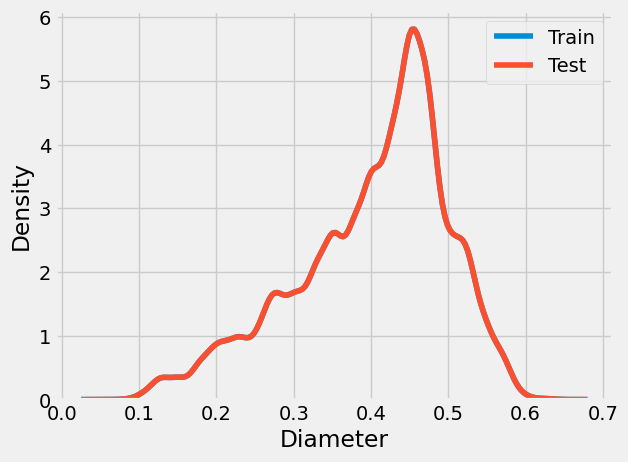

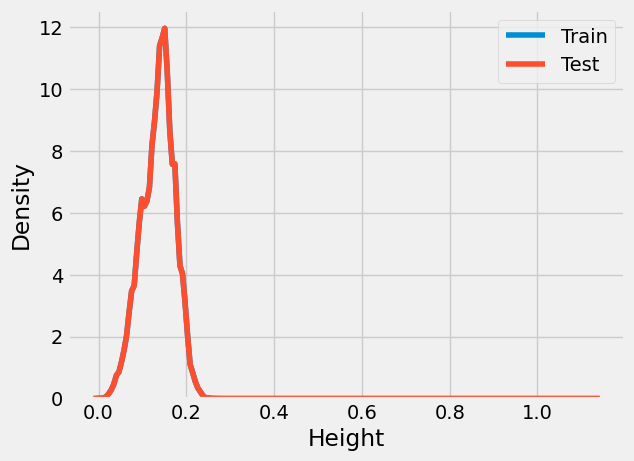

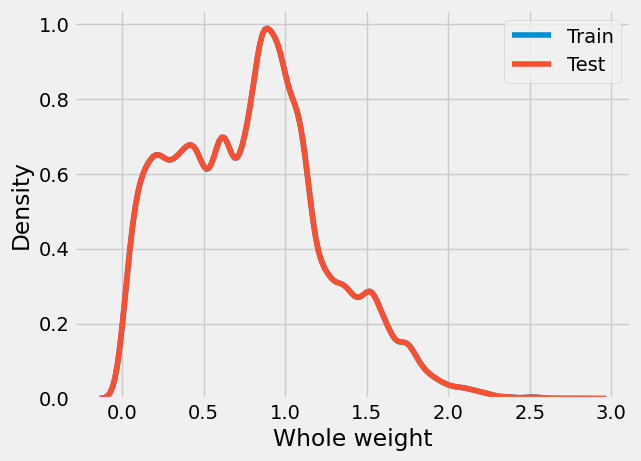

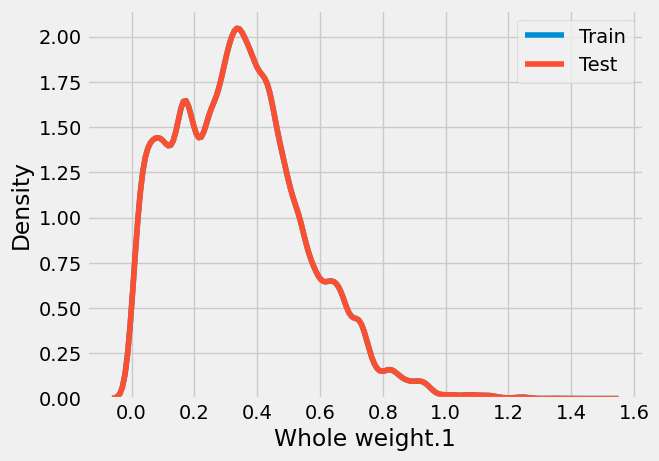

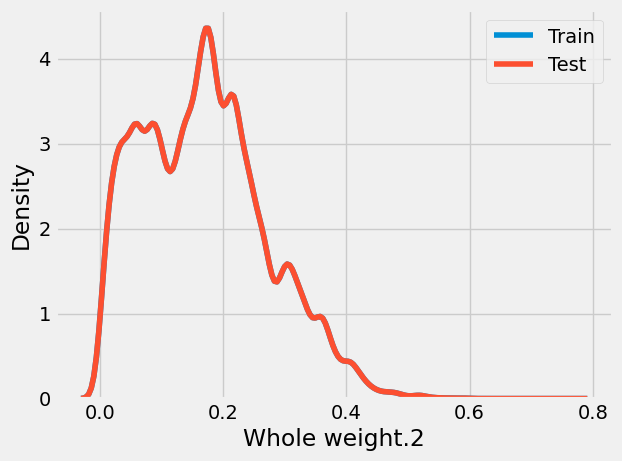

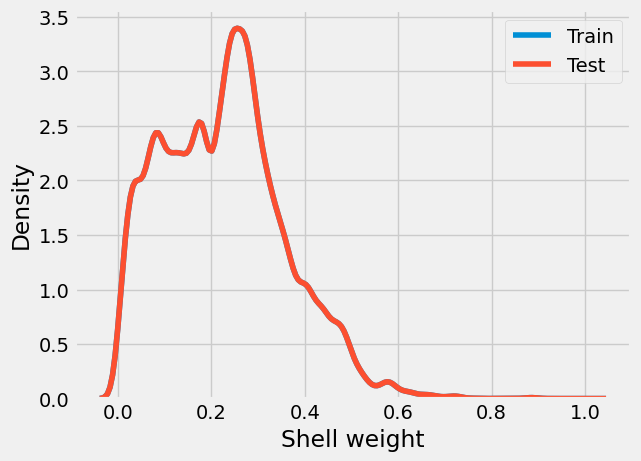

In [31]:
cols = train.drop(columns=['id', 'Rings', 'Sex']).columns.tolist()

for col in cols:
    
    sns.kdeplot(data=train, x=col, label='Train')
    sns.kdeplot(data=train, x=col, label='Test')
    plt.legend()
    
    plt.show()

In [ ]:
def cv_model(train, test, n=5):
    
    label = train['Rings']
    X = train.drop(columns=['Rings', 'id'])
    test = test.drop(columns=['id'])
    
    SKFold = StratifiedGroupKFold(n_splits=n, shuffle=True, random_state=seed)
    
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': 0.03,
        'max_depth': 8,
        'subsample': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda':0.1,
        'verbose': -1,
        'seed': seed
    }
    
    predictions = np.zeros((n, len(test))                                                                                                )
    
    fold = 0
    for train_index, val_index in SKFold.split(X, label):
        
        print(f"{fold + 1} fold  -----------------------------")
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = label.iloc[train_index], label.iloc[val_index]
        
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
                        params=params,
                        train_set=lgb_train,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[early_stopping(100), log_evaluation(100)]
        )
        
        predictions[fold] = model.predict(test)
        fold += 1
        
    return predictions.mean(axis=0)

predictions = cv_model(train, test)

In [ ]:
sample_submission = pd.read_csv(root_path + 'sample_submission.csv')
sample_submission.tocsv('/kaggle/working/sample_submission.csv ', index=False)